In [1]:
import os
import glob
import pickle
from tqdm import tqdm
import random
import pickle

from collections import Counter
import pandas as pd

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from common import Paper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def get_papers():
    concat = []

    for f in tqdm(glob.glob('./papers/*.pkl')):
        _, field, year, month = os.path.basename(f).split('.')[0].split('-')
        raw = pickle.load(open(f, 'rb'))
        concat += [x.__dict__ for x in raw]

    return pd.DataFrame(concat)

## Global definitions

In [3]:
wnl = WordNetLemmatizer()
ps = PorterStemmer()

stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(["using", "show", "result", "large", 
                               "also", "iv", "one", "two", "new", 
                               "previously", "shown"])

papers = get_papers()

100%|██████████| 540/540 [00:00<00:00, 795.72it/s]


## Clean dataset and construct corpus

#### Ensure $\geq$ N words in each abstract

In [4]:
MIN_WORDS = 20

papers['word_count'] = papers.loc[:, 'abstract'].apply(lambda x: len(str(x).split(" ")))
papers = papers[papers['word_count'] >= MIN_WORDS]

papers.word_count.describe()

count    110909.000000
mean        158.822999
std          50.537725
min          20.000000
25%         123.000000
50%         155.000000
75%         191.000000
max         559.000000
Name: word_count, dtype: float64

In [5]:
uncommon = pd.Series(' '.join(papers['abstract']).split()).value_counts()[-20:]
uncommon

24.59%                   1
"Expression              1
quasi-HMM                1
unmasks                  1
spam:                    1
$\\textit{Incremental    1
ensemble-of-models       1
McCain                   1
over-confidently         1
(ConvRNNs)               1
inadequacies.            1
36x                      1
Definition,              1
(Video:                  1
Self-balancing           1
better-tuned             1
(LGAN)                   1
augment,                 1
(1.3%                    1
HDP-HSMM                 1
dtype: int64

In [6]:
def construct_corpus(dataset):
    corpus = []
    
    for i in tqdm(range(len(dataset))):
        text = re.sub('[^a-zA-Z]', ' ', dataset.iloc[i]['abstract'])
        text = text.lower()
        text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ",text)
        text = re.sub("(\\d|\\W)+", " ", text)

        text = text.split()

        text = [wnl.lemmatize(w) for w in text if not w in stop_words] 
        text = " ".join(text)
        corpus.append(text)
        
    return corpus

corpus = construct_corpus(papers)

100%|██████████| 110909/110909 [01:01<00:00, 1815.97it/s]


#### Wordcloud

CPU times: user 32.2 s, sys: 1.1 s, total: 33.3 s
Wall time: 33.3 s


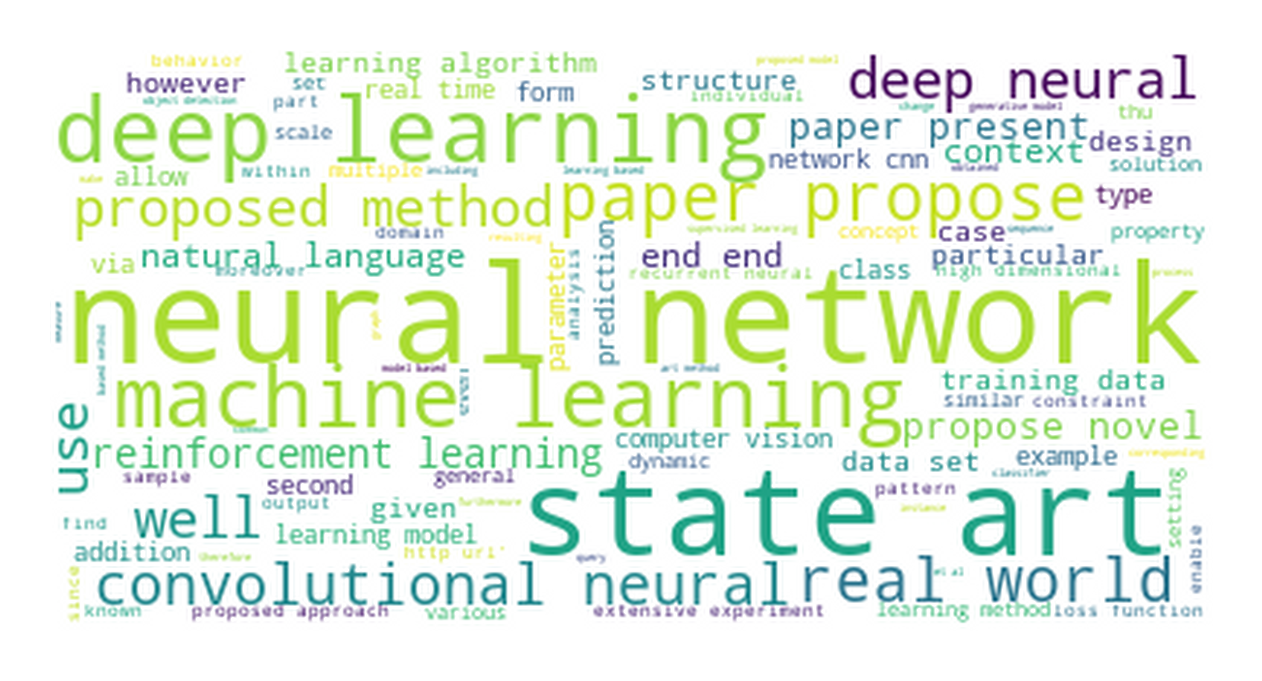

In [7]:
%%time

wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=100,
                      max_font_size=50).generate(str(corpus))

fig = plt.figure(figsize=(3, 2), dpi=250)
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
pass

#### Vectorizers

In [8]:
%%time

cv = CountVectorizer(max_df=0.8, stop_words=stop_words, max_features=10_000, ngram_range=(1,2))
X = cv.fit_transform(corpus)

tf_idf = TfidfTransformer(smooth_idf=True, use_idf=True)
tf_idf.fit(X)

features = cv.get_feature_names()

pickle.dump([cv, tf_idf, features], open('vec/cv_tfidf_feat.pkl', 'wb'))

CPU times: user 25 s, sys: 486 ms, total: 25.5 s
Wall time: 25.5 s


In [9]:
def get_keywords(doc, n=5, only_words=False):
    tf_idf_vec = tf_idf.transform(cv.transform([doc]))
    
    coo = tf_idf_vec.tocoo()
    sorted_items = sorted(zip(coo.col, coo.data), key=lambda x: (x[1], x[0]), reverse=True)
    
    if only_words:
        return [features[idx] for (idx, _) in sorted_items[:n]]
    
    return {features[idx]: round(score, 3) for (idx, score) in sorted_items[:n]}

## Testing

In [10]:
doc_idx  = random.randint(0, len(corpus))
keywords = get_keywords(corpus[doc_idx], n=10)

print(doc_idx)
print("\nAbstract:")
print(papers.iloc[doc_idx]['abstract'])
print("\nKeywords:")
for kw, score in keywords.items():
    print(f'{kw:>32s}: {score}')

18133

Abstract:
We examine a new approach to modeling uncertainty based on plausibility measures, where a plausibility measure just associates with an event its plausibility, an element is some partially ordered set. This approach is easily seen to generalize other approaches to modeling uncertainty, such as probability measures, belief functions, and possibility measures. The lack of structure in a plausibility measure makes it easy for us to add structure on an "as needed" basis, letting us examine what is required to ensure that a plausibility measure has certain properties of interest. This gives us insight into the essential features of the properties in question, while allowing us to prove general results that apply to many approaches to reasoning about uncertainty. Plausibility measures have already proved useful in analyzing default reasoning. In this paper, we examine their "algebraic properties," analogues to the use of + and * in probability theory. An understanding of such

In [ ]:
def search_by_keyword(kw, thr):
    matches = {}
    for i in tqdm(range(len(corpus)), desc='Searching'):
        kws = get_keywords(i, n=10)
        if kw in kws:
            matches[i] = kws[kw]
            
    return matches

In [ ]:
m = search_by_keyword('controller', thr=0.3)

In [ ]:
ms = sorted(m.items(), key=lambda x: x[1], reverse=True)

idx, s = ms[1]
print(f'score: {s}')
papers.iloc[idx].abstract